# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



In [1]:
# loading the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Embedding, Dense, Softmax, Dot, concatenate, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy

<font color='blue'>**Load the data**</font>

In [2]:
# reading the data and storing all the english and italian sentences in a dataframe
eng = [] # storing the english sentences.
ita = [] # storing the italian sentences

with open('ita.txt', 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        ln = line.split('\t')
        # storing the english and the italian parts in the lists
        eng.append(ln[0])
        ita.append(ln[1])

In [27]:
# checking for the lengths of the lists to be the same
assert len(eng) == len(ita)
print(len(eng))

345244


In [28]:
# making the dataframe
sentences = pd.DataFrame({'english':eng, 'italian':ita})
print(sentences.shape)
sentences.head()

(345244, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [29]:
# saving this on the disk
sentences.to_csv('sentences.csv', index=False)

In [2]:
# loading the data
sentences = pd.read_csv('sentences.csv')
print(sentences.shape)
sentences.head()

(345244, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='blue'>**Preprocess data**</font>

First, we are going to preprocess the english sentences. For that, we are going to:
1. Expand abbreviations such as can't to can not, won't to will not etc.
2. Removing punctuations.
3. Turning each character into lowercase.

In [3]:
def decontract(text):
    '''
        This function expands words like, can't ---> can not,
                                          won't ---> will not etc.
    '''
    # specific ones
    txt = re.sub("can\'t", 'can not', text)
    txt = re.sub("won\'t", 'will not', txt)
    
    # general ones
    txt = re.sub("n\'t", ' not', txt)
    txt = re.sub("\'re", ' are', txt)
    txt = re.sub("\'s", ' is', txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'t", " not", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'m", " am", txt)
    
    return txt

def preprocess(text):
    '''
        This function first decontracts the text and them removes any punctuation marks from the sentence.
        It removes everything that is not an alphabet, a number or a space from the sentences. It then converts everything into lowercase.
    '''
    # first decontracting the text
    txt = decontract(text)
    # removing everything except [A-Za-z0-9 ]
    txt = re.sub('[^A-Za-z0-9 ]+', '', txt)
    # turning everything into lowercase
    txt = txt.lower()
    return txt

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = text.lower()
    text = decontract(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


In [4]:
processed_sent = pd.DataFrame({})
# preprocessing both the italian and english sentences
processed_sent['italian'] = sentences['italian'].apply(preprocess_ita)
processed_sent['english'] = sentences['english'].apply(preprocess)
print(processed_sent.shape)
processed_sent.head()

(345244, 2)


,italian,english
0,ciao,hi
1,corri,run
2,corra,run
3,correte,run
4,chi,who


In [25]:
# saving the processed sentences to the disk
processed_sent.to_csv('processed_sentences.csv', index=False)

In [2]:
# loading the processed sentences dataframe
processed_sent = pd.read_csv('processed_sentences.csv')
print(processed_sent.shape)
processed_sent.head()

(345244, 2)


,italian,english
0,ciao,hi
1,corri,run
2,corra,run
3,correte,run
4,chi,who


Now that we have preprocessed the sentences, we will prepare the encoder input, the decoder input and the decoder outputs that we will give to the models for training. However, before that, we will be setting a maximum word length for both the languages and then keep only those sentences that have word counts less than the maximum word count.
___
From the reference notebook, we have seen that the maximum_length==20 is a good choice. Thus we are choosing max length = 20 for both the languages.

In [3]:
# filtering sentences with words > 20
processed_sent = processed_sent[processed_sent['english'].str.split().apply(len)<20]
processed_sent = processed_sent[processed_sent['italian'].str.split().apply(len)<20]

print(processed_sent.shape)

# making two new sentences for the english sentences, adding the tokens <start> to the first and <end> to the second token.
# the first one will be given to the decoder as the input while the second one will be given to the decoder as the output.
# this is to do teacher forcing to the decoder model.
eng_inp = ['<start> '+sent for sent in processed_sent['english']]
eng_out = [sent+' <end>' for sent in processed_sent['english']]

# adding the sentences to the dataframe
processed_sent['english_input'] = eng_inp
processed_sent['english_output'] = eng_out

print(processed_sent.shape)
processed_sent.head()

(344816, 2)
(344816, 4)


,italian,english,english_input,english_output
0,ciao,hi,<start> hi,hi <end>
1,corri,run,<start> run,run <end>
2,corra,run,<start> run,run <end>
3,correte,run,<start> run,run <end>
4,chi,who,<start> who,who <end>


In [4]:
# dropping the english column from the dataframe
processed_sent = processed_sent.drop(columns='english')

#### Train-test split
Now, we are going to split the data into training and testing sets. We are going to make an 80-20 split.

In [5]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(processed_sent, test_size=0.2, random_state=0)
print(train.shape, validation.shape)
train.head()

(275852, 3) (68964, 3)


,italian,english_input,english_output
210312,io devo dire che mi dispiace,<start> i have to say that i am sorry,i have to say that i am sorry <end>
129694,hai degli amici,<start> do you have any friends,do you have any friends <end>
141147,dobbiamo vincere questa,<start> we need to win this one,we need to win this one <end>
158282,perché sa tutto questo,<start> why do you know all this,why do you know all this <end>
89813,non sono vegetariana,<start> i am not a vegetarian,i am not a vegetarian <end>


In [6]:
validation.head()

,italian,english_input,english_output
183327,lei si prese cura della bambina,<start> she took care of the child,she took care of the child <end>
315271,quasi tutti quelli che conosco sanno nuotare,<start> almost everyone i know knows how to swim,almost everyone i know knows how to swim <end>
258484,deve farlo immediatamente,<start> you ought to do that right away,you ought to do that right away <end>
332448,mia madre non fa più il bucato per me,<start> my mother does not do my laundry for m...,my mother does not do my laundry for me anymor...
133231,ho bisogno di un saldatore,<start> i need a soldering iron,i need a soldering iron <end>


#### Tokenizing the english and italian sentences.

In [8]:
# for italian
tokenizer_ita = Tokenizer()
# fitting on italian training data
tokenizer_ita.fit_on_texts(train['italian'])

# for english
tokenizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') # we need to remove < and > because of the start and end tokens.

# we will add the <end> token once more to the first row of the english sentences so that we can use a single tokenizer for
# both the decoder inputs and outputs.
train.iloc[0]['english_input'] = str(train.iloc[0]['english_input']) + ' <end>'
train.iloc[0]['english_output'] = str(train.iloc[0]['english_output']) + ' <end>'

# now, we can fit the english tokenizer on just the inputs and use it for both inputs and outputs
tokenizer_eng.fit_on_texts(train['english_input'])

In [9]:
train.head(1)

,italian,english_input,english_output
210312,io devo dire che mi dispiace,<start> i have to say that i am sorry <end>,i have to say that i am sorry <end> <end>


In [10]:
print(tokenizer_eng.word_index['<start>'], tokenizer_eng.word_index['<end>'])

1 10147


In [11]:
# lets see the number of words in the english and italian vocabulary
ita_vocab_size = len(tokenizer_ita.word_index)
print('Vocabulary size for Italian:', ita_vocab_size)
eng_vocab_size = len(tokenizer_eng.word_index)
print('Vocabulary size for English:', eng_vocab_size)

Vocabulary size for Italian: 26253
Vocabulary size for English: 12859


In [12]:
# loading the glove vectors for english words from the disk
glove_vectors = {}
with open('glove.6B.100d.txt', encoding='utf-8') as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector
        
print(len(glove_vectors))

400000


In [13]:
# making a matrix of embeddings based on the vocabulary of the tokenizer
embeddings = np.zeros((len(tokenizer_eng.word_index)+1, 100))

# adding the vectors from the dictionary to the correct index
for word, ind in tokenizer_eng.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        embeddings[ind] = vector

print(embeddings.shape)

(12860, 100)


## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [7]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        # initializing the required variables
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        
    def build(self, input_shape):
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.inp_vocab_size,
                                  output_dim=self.embedding_size,
                                  input_length=self.input_length,
                                  mask_zero=True, name='Encoder_Embedding')
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(units=self.lstm_size, return_sequences=True, return_state=True, name='Encoder_LSTM')

    def call(self,input_sequence, initial_state=None):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        embedding_output = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(embedding_output)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.lstm_state_h = np.zeros((batch_size, self.lstm_size))
        self.lstm_state_c = np.zeros((batch_size, self.lstm_size))
        return self.lstm_state_h, self.lstm_state_c

<font color='orange'>**Grader function - 1**</font>

In [14]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [8]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        # initializing the required variables first
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                                  mask_zero=True, name='Decoder_Embedding', trainable=False, weights=[embeddings])
        #Intialize Decoder LSTM layer
        self.lstm = LSTM(units=self.lstm_size, return_sequences=True, return_state=True, name='Decoder_LSTM')
        

    def call(self,input_sequence,initial_state):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        embedding = self.embedding(input_sequence)
        lstm_output, lstm_state_h, lstm_state_c = self.lstm(embedding, initial_state=initial_state)
        return lstm_output, lstm_state_h, lstm_state_c
      


<font color='orange'>**Grader function - 2**</font>

In [115]:
# NOTE: For the decoder, making the embedding layer trainable and not passing the embeddings for english results in the
# grader_decoder() returning True
# However, since we are using the pretrained word embeddings here, the embedding vocab_size and output dimensions are 
# predefined to be eng_vocab_size+1 and 100 respectively and thus the grader_function returns false.
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [9]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, enc_input_length, dec_inp_length, out_vocab_size):
        '''
            enc_inp_length = length of each italian sentence
            dec_inp_length = length of each english sentence
            out_vocab_size = vocabulary size of english words for the output english sentences.
        '''
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(ita_vocab_size+1, embedding_size=50, lstm_size=256, input_length=enc_input_length)
        #Create decoder object
        self.decoder = Decoder(eng_vocab_size+1, embedding_size=100, lstm_size=256, input_length=dec_inp_length)
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.softmax = Dense(out_vocab_size, activation='softmax')
    
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        enc_inp, dec_inp = data[0], data[1]
        # getting the outputs, h and c from the encoder
        encoder_out, encoder_state_h, encoder_state_c = self.encoder(enc_inp)
        # passing the decoder input sentence, encoder h and c to the decoder
        decoder_out, dec_state_h, dec_state_c = self.decoder(dec_inp, initial_state = [encoder_state_h, encoder_state_c])
        # getting the softmax probabilities
        softmax_out = self.softmax(decoder_out)
        print(softmax_out.shape)
        
        return softmax_out

#### Preparing the data and training the model.

In [60]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_input'].values
        self.decoder_outs = data['english_output'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [61]:
# making the train and testing datasets
train_dataset = Dataset(train, tokenizer_ita, tokenizer_eng, 20)
test_dataset  = Dataset(validation, tokenizer_ita, tokenizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=256)
test_dataloader = Dataloder(test_dataset, batch_size=256)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(256, 20) (256, 20) (256, 20)


#### Model 
Here, the decoder lstm returns all the three outputs, i.e. the lstm outputs, hidden state and cell state.
i.e. 
call() returns self.lstm_outputs, self.decoder_state_h and self.decoder_state_c

In [20]:
tf.keras.backend.clear_session()
#Create an object of encoder_decoder Model class, 
encoder_decoder_model2 = Encoder_decoder(enc_input_length=20, dec_inp_length=20, out_vocab_size=eng_vocab_size)
# Compile the model and fit the model
encoder_decoder_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [21]:
# tensorboard
from tensorflow.keras.callbacks import TensorBoard

logdir = 'Logs\\Seq2Seq2'
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_grads=True)
callbacks = [tensorboard]

In [22]:
# fitting the model
train_steps=train.shape[0]//256
valid_steps=validation.shape[0]//256
encoder_decoder_model2.fit(train_dataloader, steps_per_epoch=1077, epochs=30, validation_data=test_dataloader, validation_steps=1077, callbacks=callbacks)
encoder_decoder_model2.summary()

(None, 20, 12859)
  ...
    to  
  ['...']
Train for 1077 steps, validate for 1077 steps
Epoch 1/30
(None, None, 12859)
(None, None, 12859)
1077/1077 [==============================] - 201s 187ms/step - loss: 7.0806 - val_loss: 6.1334
Epoch 2/30
1077/1077 [==============================] - 194s 180ms/step - loss: 5.3229 - val_loss: 4.5189
Epoch 3/30
1077/1077 [==============================] - 198s 184ms/step - loss: 3.7858 - val_loss: 3.0435
Epoch 4/30
1077/1077 [==============================] - 194s 180ms/step - loss: 2.3911 - val_loss: 1.7578
Epoch 5/30
1077/1077 [==============================] - 194s 180ms/step - loss: 1.3177 - val_loss: 0.9414
Epoch 6/30
1077/1077 [==============================] - 194s 180ms/step - loss: 0.7537 - val_loss: 0.5848
Epoch 7/30
1077/1077 [==============================] - 194s 180ms/step - loss: 0.5108 - val_loss: 0.4234
Epoch 8/30
1077/1077 [==============================] - 194s 180ms/step - loss: 0.3901 - val_loss: 0.3335
Epoch 9/30
1077/1077 [=

In [24]:
# saving the model weights
encoder_decoder_model2.save_weights('Seq2Seqwt2.h5')

#### Translating a few sentences and calculating the bleu score

In [38]:
def predict(input_sentence):
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    # tokenize the sentence
    inp_tokens = np.asarray(tokenizer_ita.texts_to_sequences([input_sentence]))
    if inp_tokens.size == 0: # if ther input is only one word which is not present in the vocabulary
        inp_tokens = np.array([[1]])
    # passing the sentence to the encoder and getting encoder outputs, final hidden state and cell states
    encoder = encoder_decoder_model2.layers[0]
    enc_states = encoder.initialize_states(1)
    enc_out, enc_state_h, enc_state_c = encoder(inp_tokens, enc_states)
    
    
    # passing the encoder outputs to the decoder and predictng the translation
    start_token = '<start>' # the starting sequence as input to the decoder
    output = [] # for storing the final output
    states = [enc_state_h, enc_state_c]
    decoder = encoder_decoder_model2.layers[1]
    dense = encoder_decoder_model2.layers[2]
    dec_inp = np.asarray(tokenizer_eng.texts_to_sequences([start_token]))
    
    # looping
    iteration = 0 # for counting the number of instances already predicted
    while True:
        # making predictions using the decoder
        pred_out, state_h, state_c = decoder(dec_inp, states)
        # passing the pred_out to the dense model for prediction
        # passing pred out to the softmax layer
        soft_out = dense(pred_out)
        
        # updating the states
        states = [state_h, state_c]
        
        # getting the word corresponding to the largest probability value
        ind = np.argmax(soft_out)
        # getting the word and appending to the final list
        wrd = list(tokenizer_eng.word_index.keys())[ind-1]
        
        # updating the dec_inp
        dec_inp = np.asarray(tokenizer_eng.texts_to_sequences([wrd]))
        output.append(wrd) # appending the word to the output list
        if wrd=='<end>':
            return " ".join(output)
        
        # adding 1 to the iteration count
        iteration+=1
        if iteration==20:
            return " ".join(output)

print("Original Sentence:", train['italian'].iloc[1501])
print("Translated using Seq2Seq:", predict(train['italian'].iloc[1501]))
print("Actual Translation:", train['english_output'].iloc[1501])

Original Sentence: tom non ha risposto al telefono
Translated using Seq2Seq: tom did not answer the phone <end>
Actual Translation: tom did not answer the phone <end>


In [43]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu

# taking 1000 sentences from test data randomly
# sample = validation.sample(n=1000, random_state=1)
sample = validation.iloc[:1000]
print(sample.shape)
sample.head()

(1000, 3)


,italian,english_input,english_output
183327,lei si prese cura della bambina,<start> she took care of the child,she took care of the child <end>
315271,quasi tutti quelli che conosco sanno nuotare,<start> almost everyone i know knows how to swim,almost everyone i know knows how to swim <end>
258484,deve farlo immediatamente,<start> you ought to do that right away,you ought to do that right away <end>
332448,mia madre non fa più il bucato per me,<start> my mother does not do my laundry for m...,my mother does not do my laundry for me anymor...
133231,ho bisogno di un saldatore,<start> i need a soldering iron,i need a soldering iron <end>


In [41]:
from tqdm import tqdm
# getting translations for the sample italian sentences
sample_translations = []

for sent in tqdm(sample['italian']):
    trans = predict(sent)
    sample_translations.append(trans)

print(len(sample_translations))

# printing some translations
for i in range(5):
    print('Original Italian sentence:', sample.iloc[i]['italian'])
    print('Actual English Translation:', sample.iloc[i]['english_output'])
    print('Translation done by the model:', sample_translations[i])
    print('-'*100)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.28it/s]

1000
Original Italian sentence: lei si prese cura della bambina
Actual English Translation: she took care of the child <end>
Translation done by the model: she took care of the child <end>
----------------------------------------------------------------------------------------------------
Original Italian sentence: quasi tutti quelli che conosco sanno nuotare
Actual English Translation: almost everyone i know knows how to swim <end>
Translation done by the model: almost everyone i know can swim <end>
----------------------------------------------------------------------------------------------------
Original Italian sentence: deve farlo immediatamente
Actual English Translation: you ought to do that right away <end>
Translation done by the model: you must do that right away <end>
----------------------------------------------------------------------------------------------------
Original Italian sentence: mia madre non fa più il bucato per me
Actual English Translation: my mother does 

In [82]:
# calculating bleu score for each sentence
bleu_scores = [bleu.sentence_bleu([sample['english_output'].iloc[i].split()[:-1]], sample_translations[i].split()[:-1]) for i in range(1000)]

# calculating the average bleu score
print("Aerage bleu score:", sum(bleu_scores)/len(bleu_scores))

Aerage bleu score: 0.5955364678958157


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [7]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        # initializing the important variables
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.inp_vocab_size+1, output_dim=self.embedding_size,
                                   input_length=self.input_length, mask_zero=True, name='Encoder_Embeddings')
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(units=self.lstm_size, return_sequences=True, return_state=True, name='Encoder_LSTM', kernel_initializer='he_normal')

    def call(self,input_sequence,states=None):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        embeddings_out = self.embedding(input_sequence)
        lstm_out, self.encoder_state_h, self.encoder_state_c = self.lstm(embeddings_out, initial_state=states)
        return lstm_out, self.encoder_state_h, self.encoder_state_c
        

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.encoder_state_h = tf.zeros((batch_size, self.lstm_size))
        self.encoder_state_c = tf.zeros((batch_size, self.lstm_size))
        return self.encoder_state_h, self.encoder_state_c


<font color='cyan'>**Grader function - 1**</font>

In [8]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [8]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        super(Attention, self).__init__()
        # Please go through the reference notebook and research paper to complete the scoring functions
        self.scoring_function = scoring_function
        self.att_units = att_units

        if scoring_function == 'general':
            # Intialize variables needed for General score function here
            # dense layer
            self.dense = Dense(units=self.att_units)

        elif scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            self.W1 = Dense(self.att_units)
            self.W2 = Dense(self.att_units)
            self.fin = Dense(1)
  
    def call(self,decoder_hidden_state,encoder_output):
        '''
        Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
        * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
        '''
        if self.scoring_function == 'dot':
            # Implement Dot score function here|
            # first, we need to reshape the decoder_hidden state from (batch_size, att_units) to (batch_size, att_units, 1)
            decoder_hidden_state = tf.reshape(decoder_hidden_state, shape=(tf.shape(decoder_hidden_state)[0],1,tf.shape(decoder_hidden_state)[1])) # tf.expand_dims(decoder_hidden_state, axis=-1)
            # calcluating similarities
            score = tf.matmul(decoder_hidden_state, encoder_output, transpose_b=True)
            # transposing score
            score = tf.transpose(score, [0,2,1])

        elif self.scoring_function == 'general':
            # Implement General score function here
            # reshaping the decoder hidden state
            decoder_hidden_state = tf.reshape(decoder_hidden_state, shape=(tf.shape(decoder_hidden_state)[0],1,tf.shape(decoder_hidden_state)[1]))
            # calculating similarities
            score = tf.matmul(decoder_hidden_state, self.dense(encoder_output), transpose_b=True) # this will return an array of shape (batch_size,1,inputs)
            # transposing
            score = tf.transpose(score, [0,2,1])
            
        elif self.scoring_function == 'concat':
            # Implement General score function here
            # calculating the similarities            
            # FINAL
            # reshaping inputs from the decoder
            decoder_hidden_state = tf.reshape(decoder_hidden_state, shape=(tf.shape(decoder_hidden_state)[0], 1, tf.shape(decoder_hidden_state)[1]))
            # applying tanh
            inter_ = tf.tanh(self.W1(encoder_output) + self.W2(decoder_hidden_state))
            # calculating final score
            score = self.fin(inter_)
        
        # applying softmax to get the attention weights
        attention_wts = tf.nn.softmax(score, axis=1) # this will be of the shape (batch_size,input_length,1)
        # print(attention_wts)
        # now, calculating the context vector by multiplying each wt to the corresponding encoder hidden state
        context_vector = tf.matmul(attention_wts, encoder_output, transpose_a=True)
        context_vector = tf.reshape(context_vector, shape=(tf.shape(context_vector)[0] ,tf.shape(context_vector)[2]))
        return context_vector, attention_wts

<font color='cyan'>**Grader function - 2**</font>

In [10]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [9]:
class OneStepDecoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(OneStepDecoder, self).__init__()
        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        
        # embedding layer
        self.embedding = Embedding(input_dim=self.tar_vocab_size+1, output_dim=self.embedding_dim, mask_zero=True, input_length=self.input_length,
                                   name='Decoder_embedding')
        # attention layer
        self.attention = Attention(self.score_fun, self.att_units)
        # lstm layer
        self.lstm = LSTM(units=self.dec_units, return_state=True, return_sequences=True, name='Decoder_LSTM')
        # dense layer
        self.dense = Dense(self.tar_vocab_size)
        
    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        '''
            One step decoder mechanisim step by step:
          A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
          B. Using the encoder_output and decoder hidden state, compute the context vector.
          C. Concat the context vector with the step A output
          D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
          E. Pass the decoder output to dense layer(vocab size) and store the result into output.
          F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # getting the embeddings for the input
        embedding_out = self.embedding(input_to_decoder)
        context_vector, attention_wts = self.attention(state_h, encoder_output)
        context_out = context_vector
        # the embedding_out is of shape (batch_size,1,embedding_dim) and the context vector is of shape (batch_size,att_units)
        # thus, we need to reshape the context vector to be (batch_size,1,attention_units) so that we can concatenate them
        context_vector = tf.reshape(context_vector, shape=(tf.shape(context_vector)[0],1,tf.shape(context_vector)[1]))
        # concatenating the context vector by concatenating
        concat_out = concatenate([embedding_out, context_vector])
        # print('Concatenation successfull')
        # passing concat_out to the lstm
        lstm_out, state_h, state_c = self.lstm(concat_out, initial_state=[state_h, state_c])
        # passing to the dense layer - since we are passing one time step to the lstm, the output and hidden state will be
        # same with just different shapes. Thus to get the output of shape (batch_size, tar_vocab_size), we will reshape the
        # lstm output
        lstm_out = tf.reshape(lstm_out, shape=(tf.shape(lstm_out)[0], tf.shape(lstm_out)[2]))
        output = self.dense(lstm_out)
        
        return output, state_h, state_c, attention_wts, context_out


<font color='cyan'>**Grader function - 3**</font>

In [12]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=1,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super(Decoder, self).__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        # initializing the onestepdecoder
        self.onestepdecoder = OneStepDecoder(tar_vocab_size=self.out_vocab_size, embedding_dim=self.embedding_dim,
                                             input_length=self.input_length, dec_units=self.dec_units, 
                                             score_fun=self.score_fun, att_units=self.att_units)
    
    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        all_outputs = tf.TensorArray(dtype=tf.float32, size=tf.shape(encoder_output)[1], name='output_arrays')
        
        #Iterate till the length of the decoder input
        for timestep in range(tf.shape(input_to_decoder)[1]):
            # Call onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, attention_wts, context_vector = self.onestepdecoder(
                input_to_decoder[:,timestep:timestep+1], encoder_output, decoder_hidden_state, decoder_cell_state)
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
            # print('-'*100)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), perm=[1,0,2])
        return all_outputs

<font color='cyan'>**Grader function - 4**</font>

In [17]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=1,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units,)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [11]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,enc_input_length,dec_input_length,batch_size,score_fun='dot'):
        #Intialize objects from encoder decoder
        super(encoder_decoder, self).__init__()
        self.enc_input_length = enc_input_length
        self.dec_input_length = dec_input_length
        self.score_fun = score_fun
        self.batch_size=batch_size
        # initializing the layers
        self.encoder = Encoder(inp_vocab_size=ita_vocab_size+1, embedding_size=50, lstm_size=128, input_length=self.enc_input_length)
        self.decoder = Decoder(out_vocab_size=eng_vocab_size+1, embedding_dim=100, input_length=self.dec_input_length, dec_units=128,
                               score_fun=self.score_fun, att_units=128)
    @tf.function
    def call(self,data):
        # splitting the data into the italian and english
        enc_inp, dec_inp = data[0], data[1]
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # initializing the encoder states
        enc_init_states = self.encoder.initialize_states(self.batch_size)
        # getting the encoder outputs
        enc_out, enc_h, enc_c = self.encoder(enc_inp, enc_init_states)
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        dec_out = self.decoder(dec_inp, enc_out, enc_h, enc_c)
        # return the decoder output
        return dec_out

<font color='blue'>**Custom loss function**</font>

In [12]:
def custom_lossfunction(targets,logits):

    # Custom loss function that will not consider the loss for padded zeros.
    # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    loss_ = loss_object(targets, logits)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [13]:
# custom data generator
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_input'].values
        self.decoder_outs = data['english_output'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

<font color='blue'>**Training**</font>

Implement dot function here.

In [14]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [15]:
# preparing the data for training
# tokenizers for italian and english words
# for italian
tokenizer_ita = Tokenizer(oov_token=1)
# fitting on italian training data
tokenizer_ita.fit_on_texts(train['italian'])

# for english
tokenizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') # we need to remove < and > because of the start and end tokens.

# we will add the <end> token once more to the first row of the english sentences so that we can use a single tokenizer for
# both the decoder inputs and outputs.
train.iloc[0]['english_input'] = str(train.iloc[0]['english_input']) + ' <end>'
train.iloc[0]['english_output'] = str(train.iloc[0]['english_output']) + ' <end>'

# now, we can fit the english tokenizer on just the inputs and use it for both inputs and outputs
tokenizer_eng.fit_on_texts(train['english_input'])

In [16]:
print(tokenizer_eng.word_index['<start>'], tokenizer_eng.word_index['<end>'])

1 10147


In [17]:
# lets see the number of words in the english and italian vocabulary
ita_vocab_size = len(tokenizer_ita.word_index)
print('Vocabulary size for Italian:', ita_vocab_size)
eng_vocab_size = len(tokenizer_eng.word_index)
print('Vocabulary size for English:', eng_vocab_size)

Vocabulary size for Italian: 26254
Vocabulary size for English: 12859


In [18]:
# making the train and testing datasets
train_dataset = Dataset(train, tokenizer_ita, tokenizer_eng, 20)
test_dataset  = Dataset(validation, tokenizer_ita, tokenizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=256)
test_dataloader = Dataloder(test_dataset, batch_size=256)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(256, 20) (256, 20) (256, 20)


In [19]:
train_steps=train.shape[0]//256
valid_steps=validation.shape[0]//256
train_steps, valid_steps

(1077, 269)

#### Fitting the model

In [239]:
# tensorboard callback
from tensorflow.keras.callbacks import TensorBoard

# tensorboard
logdir = 'Attention Logs\\Dot'
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True,  profile_batch = 100000000)

callbacks = [tensorboard]

In [240]:
tf.keras.backend.clear_session()
# create a model object
attention_model = encoder_decoder(enc_input_length=20, dec_input_length=20, batch_size=256, score_fun='dot')
# compiling the model
attention_model.compile(optimizer='adam', loss=custom_lossfunction)

In [241]:
# fitting the model - USING train data itself as the validation set
attention_model.fit(train_dataloader, steps_per_epoch=train_steps, verbose=1,
                    epochs=40, callbacks=callbacks)

Train for 1077 steps
Epoch 1/40
1077/1077 [==============================] - 189s 176ms/step - loss: 1.6386
Epoch 2/40
1077/1077 [==============================] - 183s 170ms/step - loss: 1.1412
Epoch 3/40
1077/1077 [==============================] - 184s 170ms/step - loss: 0.8602
Epoch 4/40
1077/1077 [==============================] - 184s 170ms/step - loss: 0.6542
Epoch 5/40
1077/1077 [==============================] - 184s 171ms/step - loss: 0.5074
Epoch 6/40
1077/1077 [==============================] - 183s 170ms/step - loss: 0.4067
Epoch 7/40
1077/1077 [==============================] - 181s 168ms/step - loss: 0.3357
Epoch 8/40
1077/1077 [==============================] - 181s 168ms/step - loss: 0.2840
Epoch 9/40
1077/1077 [==============================] - 185s 171ms/step - loss: 0.2452
Epoch 10/40
1077/1077 [==============================] - 185s 172ms/step - loss: 0.2157
Epoch 11/40
1077/1077 [==============================] - 183s 170ms/step - loss: 0.1925
Epoch 12/40
1077/107

__Training Tensorboard Plot:__

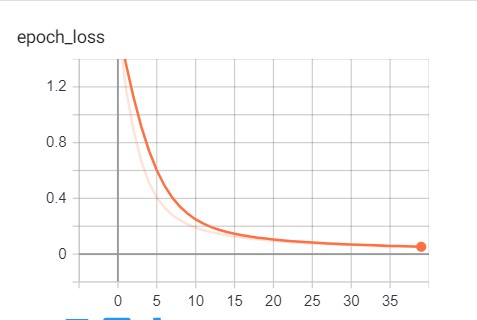

In [38]:
from IPython.display import Image
Image('Tensorboard Plots\\General.jpg')

In [242]:
attention_model.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  1404448   
_________________________________________________________________
decoder (Decoder)            multiple                  3127824   
Total params: 4,532,272
Trainable params: 4,532,272
Non-trainable params: 0
_________________________________________________________________


In [243]:
# saving
attention_model.save_weights('New Saves\\DotAttentionModel.h5')

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [24]:
import seaborn as sns
def plot_attention(att_wts, original_sentence, predicted_sentence):
    # Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
    fig, ax = plt.subplots(figsize=(10,10))
    # reshaping the weight matrix from 3-D to 2-D
    att_wts = att_wts.reshape(att_wts.shape[0], att_wts.shape[2])
    # plotting the heatmap of the weights
    sns.heatmap(att_wts, ax=ax, linewidths=0.01)
    ax.set_yticklabels(predicted_sentence.split(), rotation=360)
    ax.set_xticklabels(original_sentence.split())
    ax.set_xlabel('Italian Sentence')
    ax.set_ylabel('English Translation')
    ax.set_title('Attention Plot.')
    plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [25]:
# dictionary for converting the output tokens to english words.
eng_tokens_to_text = {v:k for k,v in tokenizer_eng.word_index.items()}

In [26]:
def predict(input_sentence, attention_model, plot_attention_wts=False):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    # converting italian words to tokens
    input_tokens = np.asarray(tokenizer_ita.texts_to_sequences([input_sentence]))
    
    ### GETTING OUTPUTS FROM THE ENCODER ###
    # passing the tokens to the encoder
    encoder = attention_model.layers[0]
    # initializing the encoder states
    enc_st = encoder.initialize_states(batch_size=1)
    enc_out, state_h, state_c = encoder(input_tokens, enc_st)
    # preparing the decoder sequence - setting the input as <start>
    dec_in = '<start>'
    output = [] # for storing the output translated sentenct
    dec_in = np.asarray(tokenizer_eng.texts_to_sequences([dec_in]))
    attention_weights = [] # list for storing the attention vectors from each timestep
    
    ### ONE STEP DECODER ###
    osd = attention_model.layers[1].layers[0] # the one step decoder object
    
    ### LOOPING AND TRANSLATING ###
    iteration = 0 # counter to keep track of number of iterations
    while True:
        out, state_h, state_c, att_wt, cont_vect = osd(dec_in, enc_out, state_h, state_c)
        # reshaping att_wt
        att_wt = np.reshape(att_wt, newshape=(att_wt.shape[0], att_wt.shape[1]))
        # appending to the list
        attention_weights.append(att_wt)

        ###  GETTING THE PREDICTED WORD, UPDATING THE VARIABLES AND TERMINATION CHECKS
        max_ind = np.argmax(out) # the index of maximum output value
        # getting the word
        wrd = eng_tokens_to_text[max_ind]
        output.append(wrd) # appending the word to the output list
        # getting its corresponding token
        dec_in = np.asarray(tokenizer_eng.texts_to_sequences([wrd]))

        ### TERMINATION CHECKS ###
        iteration += 1
        if iteration==20:
            final_sent = " ".join(output)
            break
        if wrd=='<end>': # this is surprising, the model is predicting combat instead of <end>
            final_sent = " ".join(output[:-1])
            break
    
    if plot_attention_wts==True:
        attention_weights = np.array(attention_weights[:-1])
        # plotting the attention matrix
        plot_attention(attention_weights, input_sentence, final_sent)
        
    return final_sent

#### Testing a few datapoints by plotting their attention plots.

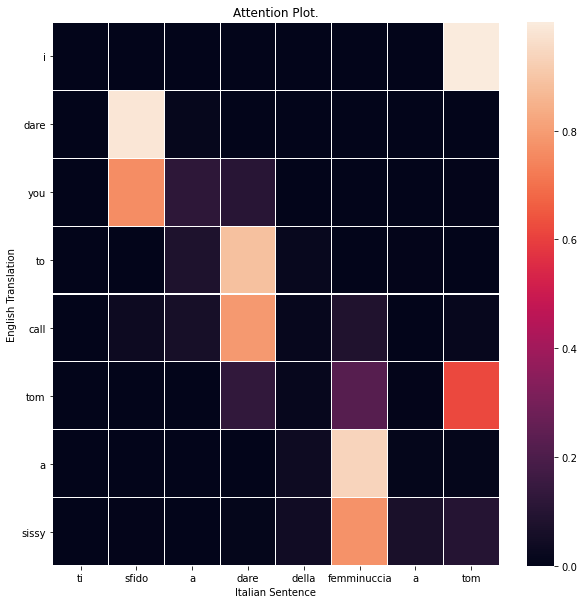

'i dare you to call tom a sissy'

In [247]:
# EXAMPLE 1
# getting the translation
sent_ind = 2248
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model, plot_attention_wts=True)
sent

In [248]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('i dare you to call tom a sissy <end>',
 'ti sfido a dare della femminuccia a tom')

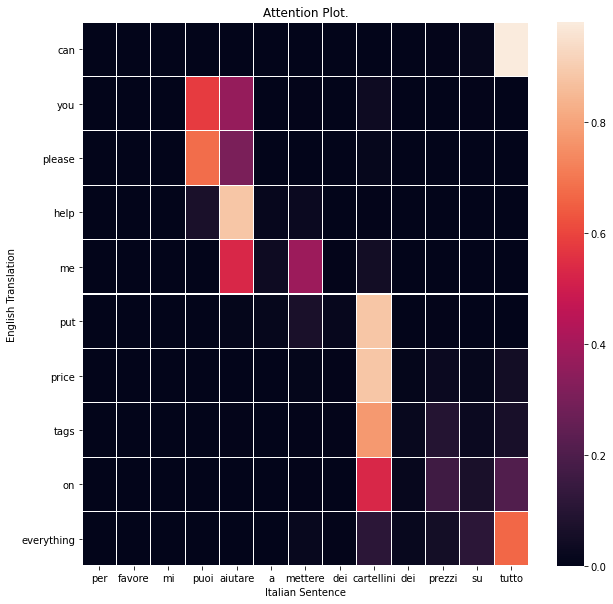

'can you please help me put price tags on everything'

In [249]:
# EXAMPLE 2
sent_ind = 44
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model, plot_attention_wts=True)
sent

In [250]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('can you please help me put price tags on everything <end>',
 'per favore mi puoi aiutare a mettere dei cartellini dei prezzi su tutto')

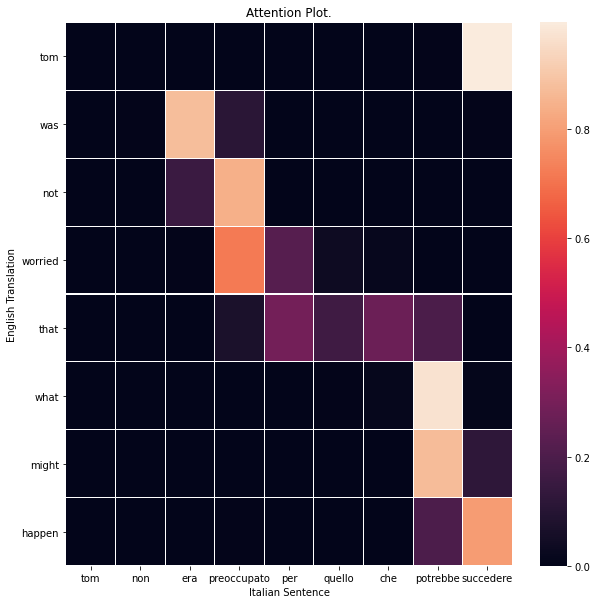

'tom was not worried that what might happen'

In [251]:
# EXAMPLE 3
sent_ind = 3985
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model, plot_attention_wts=True)
sent

In [252]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('tom was not worried about what might happen <end>',
 'tom non era preoccupato per quello che potrebbe succedere')

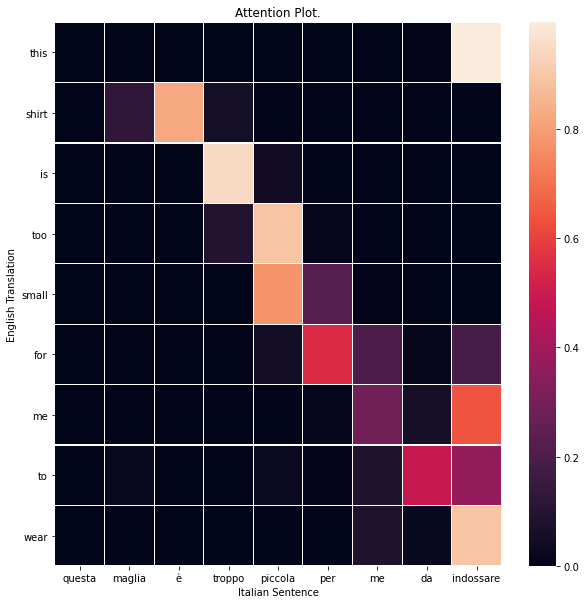

'this shirt is too small for me to wear'

In [262]:
# EXAMPLE 3
sent_ind = 444
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model, plot_attention_wts=True)
sent

In [261]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('i need a soldering iron <end>', 'ho bisogno di un saldatore')

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [36]:
import nltk.translate.bleu_score as bleu

In [32]:
# sampling 1000 sentences from the testing set at random
sample = validation.sample(n=1000, random_state=0)
print(sample.shape)
sample.head()

(1000, 3)


,italian,english_input,english_output
164120,io spero che le cose cambieranno,<start> i hope things will change,i hope things will change <end>
288665,non lo so perché non chiede a tom,<start> i do not know why do not you ask tom,i do not know why do not you ask tom <end>
210230,io non ho niente da dirti,<start> i have nothing to say to you,i have nothing to say to you <end>
282360,si dice che lui conosca il segreto,<start> it is said that he knows the secret,it is said that he knows the secret <end>
94585,a tom non è mai piaciuta mary,<start> tom never liked mary,tom never liked mary <end>


In [33]:
# translating all the sentences from the sample
translations = []
for sent in tqdm(sample['italian']):
    # translating
    trans_ = predict(sent, attention_model)
    # appending to the list
    translations.append(trans_)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.00it/s]


In [34]:
# printing a few translations
for i in range(5):
    print('Original Italian sentence:', sample.iloc[i]['italian'])
    print('Actual English Translation:', sample.iloc[i]['english_output'])
    print('Translation done by the model:', translations[i])
    print('-'*100)

Original Italian sentence: io spero che le cose cambieranno
Actual English Translation: i hope things will change <end>
Translation done by the model: i hope things are all going to change
----------------------------------------------------------------------------------------------------
Original Italian sentence: non lo so perché non chiede a tom
Actual English Translation: i do not know why do not you ask tom <end>
Translation done by the model: i do not know why you do not know tom
----------------------------------------------------------------------------------------------------
Original Italian sentence: io non ho niente da dirti
Actual English Translation: i have nothing to say to you <end>
Translation done by the model: i have got nothing to tell you
----------------------------------------------------------------------------------------------------
Original Italian sentence: si dice che lui conosca il segreto
Actual English Translation: it is said that he knows the secret <en

In [39]:
# calculating bleu score for each sentence
bleu_scores = [bleu.sentence_bleu([sample['english_output'].iloc[i].split()[:-1]], translations[i].split()[:-1]) for i in range(1000)]

# calculating the average bleu score
print("Aerage bleu score:", sum(bleu_scores)/len(bleu_scores))

Aerage bleu score: 0.37834063750642793


C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [26]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [25]:
# tensorboard callback
from tensorflow.keras.callbacks import TensorBoard

# tensorboard
logdir = 'Attention Logs\\General'
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True,  profile_batch = 100000000)

callbacks = [tensorboard]

In [28]:
tf.keras.backend.clear_session()
# create a model object
attention_model2 = encoder_decoder(enc_input_length=20, dec_input_length=20, batch_size=256, score_fun='general')
# compiling the model
attention_model2.compile(optimizer='adam', loss=custom_lossfunction)

In [32]:
# fitting the model 
attention_model2.fit(train_dataloader, steps_per_epoch=train_steps, verbose=1,
                    epochs=40, callbacks=callbacks)

Train for 1077 steps
Epoch 1/40
1077/1077 [==============================] - 190s 176ms/step - loss: 1.6723
Epoch 2/40
1077/1077 [==============================] - 185s 172ms/step - loss: 1.1953
Epoch 3/40
1077/1077 [==============================] - 186s 172ms/step - loss: 0.8912
Epoch 4/40
1077/1077 [==============================] - 193s 179ms/step - loss: 0.6692
Epoch 5/40
1077/1077 [==============================] - 186s 173ms/step - loss: 0.5132
Epoch 6/40
1077/1077 [==============================] - 186s 173ms/step - loss: 0.4066
Epoch 7/40
1077/1077 [==============================] - 186s 173ms/step - loss: 0.3333
Epoch 8/40
1077/1077 [==============================] - 186s 173ms/step - loss: 0.2802
Epoch 9/40
1077/1077 [==============================] - 185s 172ms/step - loss: 0.2434
Epoch 10/40
1077/1077 [==============================] - 186s 172ms/step - loss: 0.2127
Epoch 11/40
1077/1077 [==============================] - 185s 172ms/step - loss: 0.1902
Epoch 12/40
1077/107

__Training tensorboard plot:__

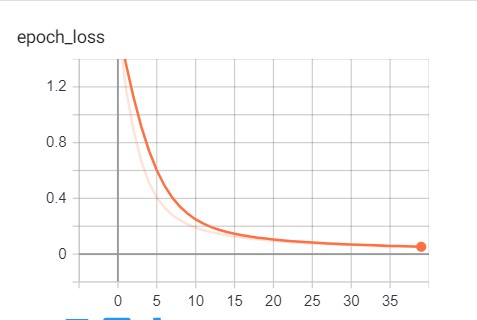

In [37]:
from IPython.display import Image
Image('Tensorboard Plots\\General.jpg')

In [33]:
# saving the model weights
attention_model2.save_weights('New Saves\\GeneralAttentionModel.h5')

In [20]:
tf.keras.backend.clear_session()
# create a model object
attention_model2 = encoder_decoder(enc_input_length=20, dec_input_length=20, batch_size=256, score_fun='general')
# compiling the model
attention_model2.compile(optimizer='adam', loss=custom_lossfunction)

In [21]:
# fitting the model 
attention_model2.fit(train_dataloader, steps_per_epoch=train_steps, verbose=1,
                    epochs=40)

Train for 1077 steps
Epoch 1/40
  10/1077 [..............................] - ETA: 12:12 - loss: 3.2695

KeyboardInterrupt: 

In [22]:
# loading the model weights
attention_model2.load_weights('New Saves\\GeneralAttentionModel.h5')

#### Translating some sentences and looking at their attention plots.

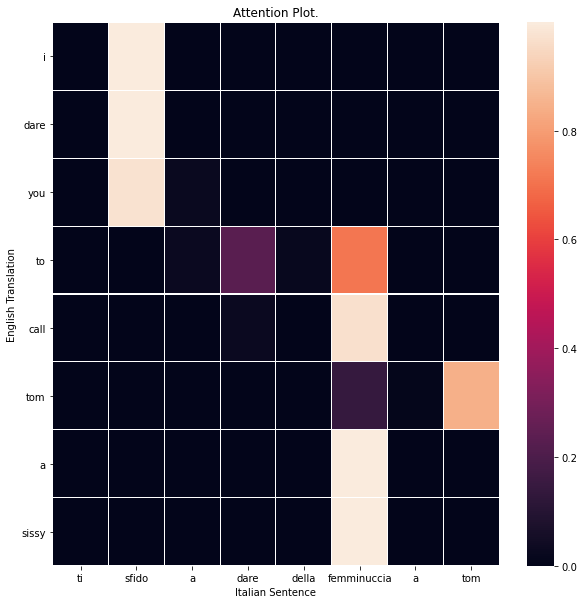

'i dare you to call tom a sissy'

In [27]:
# EXAMPLE 1
# getting the translation
sent_ind = 2248
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model2, plot_attention_wts=True)
sent

In [35]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('i dare you to call tom a sissy <end>',
 'ti sfido a dare della femminuccia a tom')

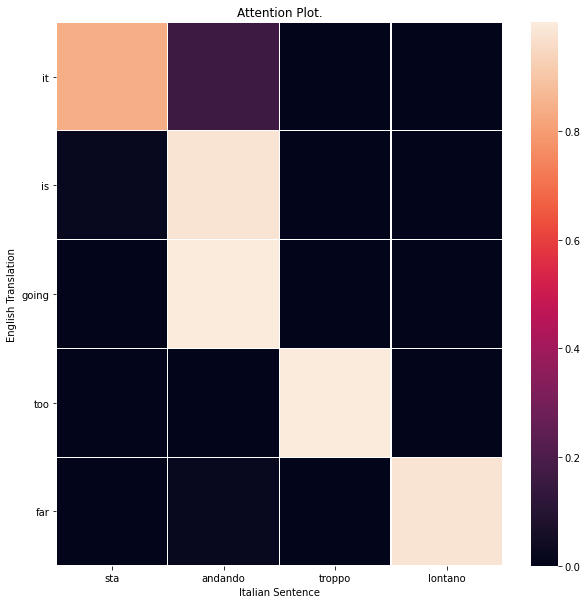

'it is going too far'

In [36]:
# EXAMPLE 2
sent_ind = 228
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model2, plot_attention_wts=True)
sent

In [37]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('you are going too far <end>', 'sta andando troppo lontano')

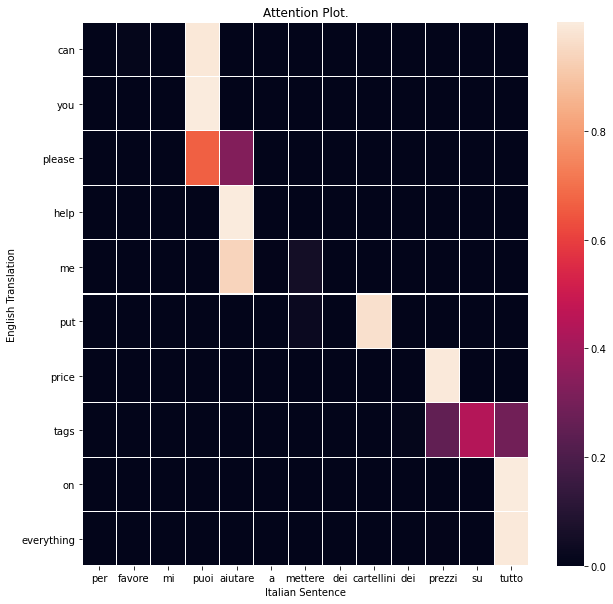

'can you please help me put price tags on everything'

In [38]:
# EXAMPLE 3
sent_ind = 44
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model2, plot_attention_wts=True)
sent

In [39]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('can you please help me put price tags on everything <end>',
 'per favore mi puoi aiutare a mettere dei cartellini dei prezzi su tutto')

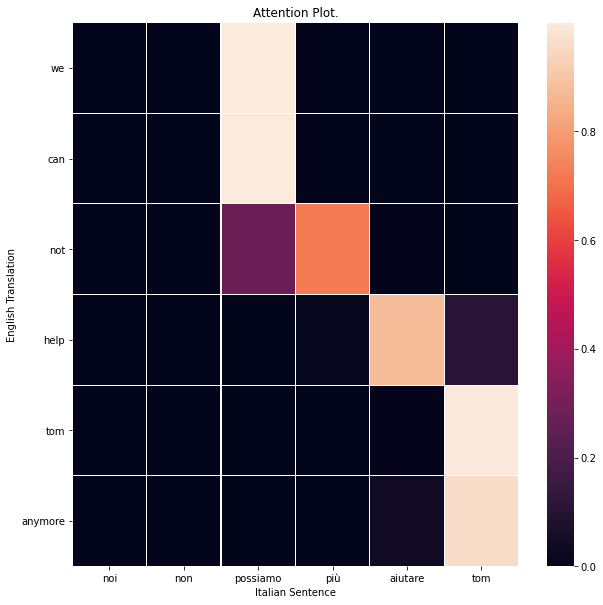

'we can not help tom anymore'

In [41]:
# EXAMPLE 3
sent_ind = 41
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model2, plot_attention_wts=True)
sent

<font color='blue'>**Calculate BLEU score**</font>

In [29]:
import nltk.translate.bleu_score as bleu

In [30]:
# sampling 1000 sentences from the testing set at random
sample = validation.sample(n=1000, random_state=0)
print(sample.shape)
sample.head()

(1000, 3)


,italian,english_input,english_output
164120,io spero che le cose cambieranno,<start> i hope things will change,i hope things will change <end>
288665,non lo so perché non chiede a tom,<start> i do not know why do not you ask tom,i do not know why do not you ask tom <end>
210230,io non ho niente da dirti,<start> i have nothing to say to you,i have nothing to say to you <end>
282360,si dice che lui conosca il segreto,<start> it is said that he knows the secret,it is said that he knows the secret <end>
94585,a tom non è mai piaciuta mary,<start> tom never liked mary,tom never liked mary <end>


In [32]:
# translating all the sentences from the sample
translations = []
for sent in tqdm(sample['italian']):
    # translating
    trans_ = predict(sent, attention_model2)
    # appending to the list
    translations.append(trans_)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.14it/s]


In [33]:
# printing a few translations
for i in range(5):
    print('Original Italian sentence:', sample.iloc[i]['italian'])
    print('Actual English Translation:', sample.iloc[i]['english_output'])
    print('Translation done by the model:', translations[i])
    print('-'*100)

Original Italian sentence: io spero che le cose cambieranno
Actual English Translation: i hope things will change <end>
Translation done by the model: i hope things will change
----------------------------------------------------------------------------------------------------
Original Italian sentence: non lo so perché non chiede a tom
Actual English Translation: i do not know why do not you ask tom <end>
Translation done by the model: i do not know why you do not ask tom
----------------------------------------------------------------------------------------------------
Original Italian sentence: io non ho niente da dirti
Actual English Translation: i have nothing to say to you <end>
Translation done by the model: i have got nothing to tell you
----------------------------------------------------------------------------------------------------
Original Italian sentence: si dice che lui conosca il segreto
Actual English Translation: it is said that he knows the secret <end>
Translatio

In [34]:
# calculating bleu score for each sentence
bleu_scores = [bleu.sentence_bleu([sample['english_output'].iloc[i].split()[:-1]], translations[i].split()[:-1]) for i in range(1000)]

# calculating the average bleu score
print("Aerage bleu score:", sum(bleu_scores)/len(bleu_scores))

Aerage bleu score: 0.40816751032667026


C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [28]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [27]:
# tensorboard callback
from tensorflow.keras.callbacks import TensorBoard

# tensorboard
logdir = 'Attention Logs\\Concat'
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True,  profile_batch = 100000000)

callbacks = [tensorboard]

In [29]:
tf.keras.backend.clear_session()
# create a model object
attention_model3 = encoder_decoder(enc_input_length=20, dec_input_length=20, score_fun='concat', batch_size=256)
# compiling the model
attention_model3.compile(optimizer='adam', loss=custom_lossfunction)

In [30]:
# fitting the model - USING train data itself as the validation set
attention_model3.fit(train_dataloader, steps_per_epoch=train_steps, verbose=1,
                    epochs=40, callbacks=callbacks)

Train for 1077 steps
Epoch 1/40
1077/1077 [==============================] - 210s 195ms/step - loss: 1.6597
Epoch 2/40
1077/1077 [==============================] - 205s 191ms/step - loss: 1.1488
Epoch 3/40
1077/1077 [==============================] - 204s 189ms/step - loss: 0.8511
Epoch 4/40
1077/1077 [==============================] - 204s 189ms/step - loss: 0.6413
Epoch 5/40
1077/1077 [==============================] - 204s 189ms/step - loss: 0.4945
Epoch 6/40
1077/1077 [==============================] - 205s 191ms/step - loss: 0.3943
Epoch 7/40
1077/1077 [==============================] - 205s 191ms/step - loss: 0.3239
Epoch 8/40
1077/1077 [==============================] - 204s 189ms/step - loss: 0.2739
Epoch 9/40
1077/1077 [==============================] - 204s 189ms/step - loss: 0.2370
Epoch 10/40
1077/1077 [==============================] - 203s 189ms/step - loss: 0.2084
Epoch 11/40
1077/1077 [==============================] - 204s 189ms/step - loss: 0.1865
Epoch 12/40
1077/107

__Training Tensorboard plot:__

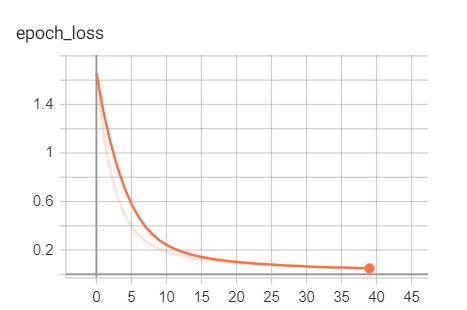

In [39]:
from IPython.display import Image
Image('Tensorboard Plots\\Concat.jpg')

In [31]:
# saving the weights
attention_model3.save_weights('New Saves\\ConcatAttentionModel.h5')

#### Testing a few datapoints by plotting their attention plots.

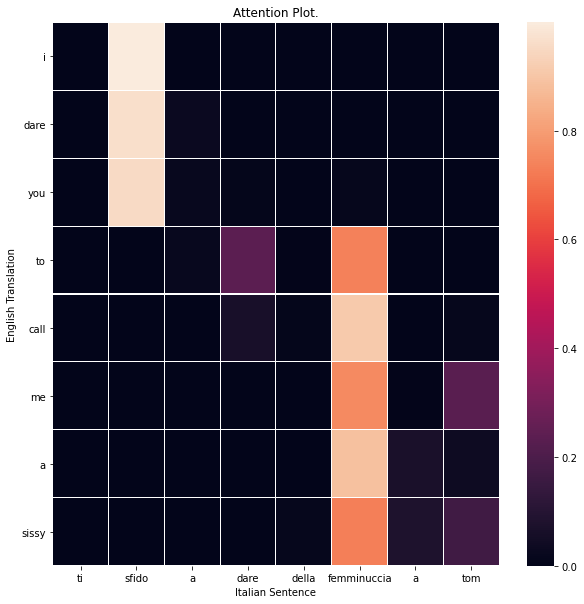

'i dare you to call me a sissy'

In [37]:
# EXAMPLE 1
# getting the translation
sent_ind = 2248
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model3, plot_attention_wts=True)
sent

In [38]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('i dare you to call tom a sissy <end>',
 'ti sfido a dare della femminuccia a tom')

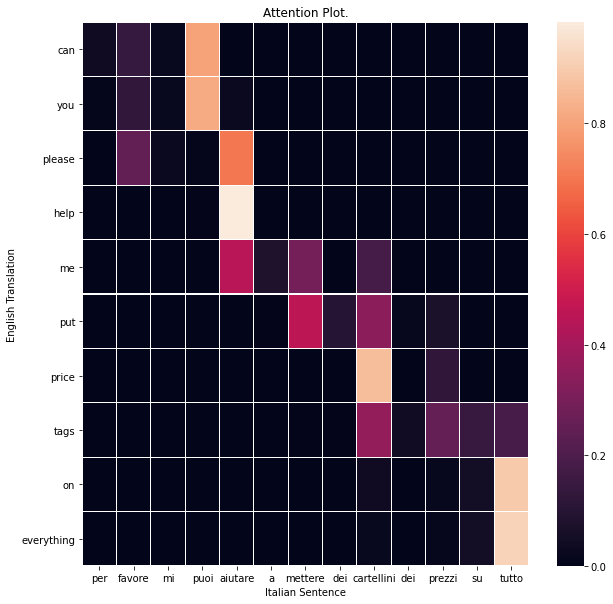

'can you please help me put price tags on everything'

In [40]:
# EXAMPLE 2
sent_ind = 44
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model3, plot_attention_wts=True)
sent

In [41]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('can you please help me put price tags on everything <end>',
 'per favore mi puoi aiutare a mettere dei cartellini dei prezzi su tutto')

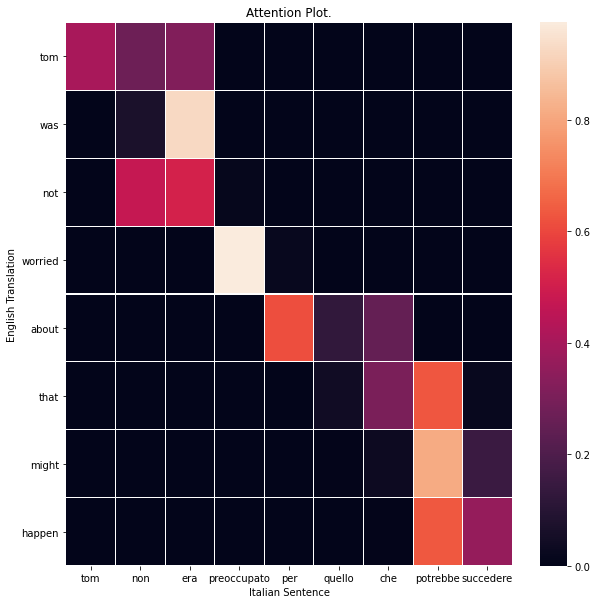

'tom was not worried about that might happen'

In [42]:
# EXAMPLE 3
sent_ind = 3985
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model3, plot_attention_wts=True)
sent

In [43]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('tom was not worried about what might happen <end>',
 'tom non era preoccupato per quello che potrebbe succedere')

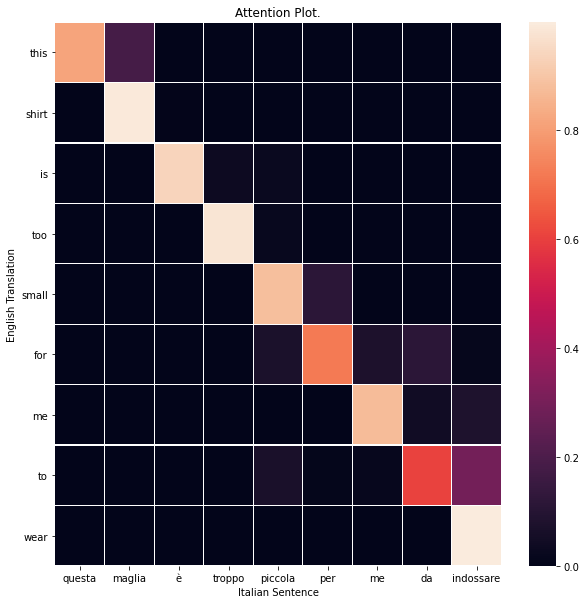

'this shirt is too small for me to wear'

In [44]:
# EXAMPLE 3
sent_ind = 444
sent = predict(validation['italian'].iloc[sent_ind], attention_model=attention_model3, plot_attention_wts=True)
sent

In [45]:
# the real sentences
validation.iloc[sent_ind]['english_output'], validation.iloc[sent_ind]['italian']

('this shirt is too small for me to wear <end>',
 'questa maglia è troppo piccola per me da indossare')

<font color='blue'>**Calculate BLEU score**</font>

In [46]:
import nltk.translate.bleu_score as bleu

In [47]:
# sampling 1000 sentences from the testing set at random
sample = validation.sample(n=1000, random_state=0)
print(sample.shape)
sample.head()

(1000, 3)


,italian,english_input,english_output
164120,io spero che le cose cambieranno,<start> i hope things will change,i hope things will change <end>
288665,non lo so perché non chiede a tom,<start> i do not know why do not you ask tom,i do not know why do not you ask tom <end>
210230,io non ho niente da dirti,<start> i have nothing to say to you,i have nothing to say to you <end>
282360,si dice che lui conosca il segreto,<start> it is said that he knows the secret,it is said that he knows the secret <end>
94585,a tom non è mai piaciuta mary,<start> tom never liked mary,tom never liked mary <end>


In [48]:
# translating all the sentences from the sample
translations = []
for sent in tqdm(sample['italian']):
    # translating
    trans_ = predict(sent, attention_model3)
    # appending to the list
    translations.append(trans_)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.15it/s]


In [49]:
# printing a few translations
for i in range(5):
    print('Original Italian sentence:', sample.iloc[i]['italian'])
    print('Actual English Translation:', sample.iloc[i]['english_output'])
    print('Translation done by the model:', translations[i])
    print('-'*100)

Original Italian sentence: io spero che le cose cambieranno
Actual English Translation: i hope things will change <end>
Translation done by the model: i hope things will change
----------------------------------------------------------------------------------------------------
Original Italian sentence: non lo so perché non chiede a tom
Actual English Translation: i do not know why do not you ask tom <end>
Translation done by the model: i do not know why do not you ask that
----------------------------------------------------------------------------------------------------
Original Italian sentence: io non ho niente da dirti
Actual English Translation: i have nothing to say to you <end>
Translation done by the model: i do not have anything from help you
----------------------------------------------------------------------------------------------------
Original Italian sentence: si dice che lui conosca il segreto
Actual English Translation: it is said that he knows the secret <end>
Tra

In [50]:
# calculating bleu score for each sentence
bleu_scores = [bleu.sentence_bleu([sample['english_output'].iloc[i].split()[:-1]], translations[i].split()[:-1]) for i in range(1000)]

# calculating the average bleu score
print("Aerage bleu score:", sum(bleu_scores)/len(bleu_scores))

Aerage bleu score: 0.40581383594455733


C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda\envs\DeepLearning\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

## Write your observations on each of the scoring function

- The BLEU Score is higher for the _concat_ and _general_ attention techniques as compared to the _Dot_ attention technique.
- The BLEU Scores for General and Concat are very similar to each other. Thus, we can conclude that the BLEU Score is not affected a lot by the attention technique choosen.
- On observing the attention plots, we can see that the model is able to decipher/understand which word(s) among the input sentence is important for a particular word in the output.
- The attention gets better from DOT to GENERAL to CONCAT as the attention mechanism becomes more and more complex.
- For this, let us take a look at the example sentence:
> __Italian:__ _per favore mi puoi aiutare a mettere dei cartellini dei prezzi su tutto._
> __English:__ _can you please help me put price tags on everything_
- We can see that the concat method gives the best attention plot for this sentence followed by the general and the dot methods respectively.
- We can see that for the example sentence, the concat technique is able to give attention with a higher precision and is also able to account for the fact that multiple words from the input sequence can be contextually important for a particular word in the output in a better manner as compared to the other two techniques.